In [1]:
# Keras-based GAN for MNIST
# -------------------------
# This script shows a minimal example of how to train a GAN on the MNIST dataset
# using TensorFlow and Keras. It defines a Generator, a Discriminator, and a
# custom "GAN" model that implements a training step combining both networks.


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt

# Hyperparameters
LATENT_DIM = 100
EPOCHS = 50  # Increased epochs for better training
BATCH_SIZE = 128  # Increased batch size for stability
LEARNING_RATE = 0.0002
BETA_1 = 0.5
DROPOUT_RATE = 0.3
ALPHA = 0.2  # LeakyReLU alpha

# Directory to save generated images
os.makedirs("gan_samples", exist_ok=True)

In [2]:
def build_generator():
    """
    Build the generator model using Keras Sequential API.
    The generator takes a latent vector of shape (LATENT_DIM,)
    and outputs a (28, 28, 1) image.
    """
    model = keras.Sequential(name="Generator")

    # Input layer
    model.add(layers.Input(shape=(LATENT_DIM,)))

    # First Dense layer with 256 units, BatchNorm, and LeakyReLU
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=ALPHA))

    # Second Dense layer with 512 units, BatchNorm, and LeakyReLU
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=ALPHA))

    # Third Dense layer with 1024 units, BatchNorm, and LeakyReLU
    model.add(layers.Dense(1024))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=ALPHA))

    # Final Dense layer with 28*28 units and tanh activation
    model.add(layers.Dense(28 * 28, activation='tanh'))

    # Reshape the output to (28, 28, 1)
    model.add(layers.Reshape((28, 28, 1)))

    return model

In [3]:
def build_discriminator():
    """
    Build the discriminator model using Keras Sequential API.
    The discriminator takes a (28, 28, 1) image and outputs a single scalar (real or fake).
    """
    model = keras.Sequential(name="Discriminator")

    # Input layer
    model.add(layers.Input(shape=(28, 28, 1)))

    # Flatten the input from (28, 28, 1) to 784
    model.add(layers.Flatten())

    # First Dense layer with 1024 units, LeakyReLU, and Dropout
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(negative_slope=ALPHA))
    model.add(layers.Dropout(DROPOUT_RATE))

    # Second Dense layer with 512 units, LeakyReLU, and Dropout
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(negative_slope=ALPHA))
    model.add(layers.Dropout(DROPOUT_RATE))

    # Third Dense layer with 256 units, LeakyReLU, and Dropout
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(negative_slope=ALPHA))
    model.add(layers.Dropout(DROPOUT_RATE))

    # Final Dense layer with 1 unit and sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [4]:
class GAN(keras.Model):
    """
    A custom Keras Model that contains both the generator and discriminator.
    The `train_step()` method overrides the default .fit() logic, combining
    the training of the discriminator and generator in one step.
    """

    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, real_images):
        """
        Perform one training step:
          1) Train discriminator on real images and fake images
          2) Train generator to fool the discriminator
        """
        batch_size = tf.shape(real_images)[0]

        # ----------------------
        # Train Discriminator
        # ----------------------
        # Sample random noise to generate fake images
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
        fake_images = self.generator(random_latent_vectors)

        # Labels for real (1) and fake (0) images with label smoothing
        real_labels = tf.ones((batch_size, 1)) * 0.9  # Label smoothing
        fake_labels = tf.zeros((batch_size, 1)) + 0.1  # Label smoothing

        # Train on real and fake images
        with tf.GradientTape() as tape:
            # Predictions for real images
            real_preds = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(real_labels, real_preds)

            # Predictions for fake images
            fake_preds = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(fake_labels, fake_preds)

            # Combine discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # ----------------------
        # Train Generator
        # ----------------------
        # Generate new random noise
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
        with tf.GradientTape() as tape:
            # The generator wants the discriminator to think these are real!
            fake_images = self.generator(random_latent_vectors, training=True)
            preds = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(real_labels, preds)  # Use real_labels to fool the discriminator

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [5]:
def save_samples(generator, epoch, n=16, sample_dir="gan_samples"):
    """
    Save a grid of generated images (n x n images total).
    """
    random_latent_vectors = tf.random.normal(shape=(n, LATENT_DIM))
    generated = generator(random_latent_vectors, training=False)
    generated = (generated * 127.5 + 127.5).numpy().astype(np.uint8)  # Denormalize from [-1,1] to [0,255]

    # Create a tiled image for easy viewing
    rows, cols = 4, 4  # for 16 images
    tiled_image = np.zeros((28 * rows, 28 * cols), dtype=np.uint8)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            img = generated[idx, :, :, 0]
            tiled_image[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
            idx += 1

    # Save the grid to a PNG
    save_path = os.path.join(sample_dir, f"epoch_{epoch:03d}.png")
    from PIL import Image
    Image.fromarray(tiled_image).save(save_path)
    print(f"Saved sample images to {save_path}")

In [6]:
def prepare_mnist_dataset(batch_size=64):
    """Load the MNIST dataset, normalize to [-1, 1], and batch it."""
    (x_train, _), (_, _) = keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32")

    # Normalize from [0, 255] to [-1, 1]
    x_train = (x_train - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)

    dataset = tf.data.Dataset.from_tensor_slices(x_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)
    return dataset

In [7]:
class LossPlotCallback(keras.callbacks.Callback):
    """
    Callback that stores the loss each epoch and plots them at the end of training.
    """

    def on_train_begin(self, logs=None):
        self.d_losses = []
        self.g_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # logs: Dictionary of metrics for this epoch, including d_loss & g_loss
        self.d_losses.append(logs.get("d_loss"))
        self.g_losses.append(logs.get("g_loss"))

    def on_train_end(self, logs=None):
        # Plot the stored losses after all epochs finish
        epochs_range = range(1, len(self.d_losses) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(epochs_range, self.d_losses, label="Discriminator Loss")
        plt.plot(epochs_range, self.g_losses, label="Generator Loss")
        plt.title("GAN Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig("loss_plot.png")
        plt.show()

In [8]:
def main():
    # Prepare dataset
    dataset = prepare_mnist_dataset(batch_size=BATCH_SIZE)

    # Build models
    generator = build_generator()
    discriminator = build_discriminator()

    # Instantiate the GAN
    gan = GAN(generator=generator, discriminator=discriminator)

    # Compile it with Adam optimizers for G and D
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
        d_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=False)
    )

    # Keras Callback to save images after each epoch
    class SampleCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            save_samples(self.model.generator, epoch + 1)

    # Train!
    gan.fit(dataset, epochs=EPOCHS, callbacks=[SampleCallback(), LossPlotCallback()])

    print("Training complete! Check the 'gan_samples' folder for generated images.")
    print("A plot of loss per epoch has been saved as 'loss_plot.png'.")

Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - d_loss: 0.6011 - g_loss: 0.9797Saved sample images to gan_samples/epoch_001.png
468/468 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - d_loss: 0.6011 - g_loss: 0.9793
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 0.6095 - g_loss: 0.9547Saved sample images to gan_samples/epoch_002.png
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 0.6096 - g_loss: 0.9552
Epoch 3/50
465/468 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 0.5992 - g_loss: 0.9838Saved sample images to gan_samples/epoch_003.png
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 0.5988 - g_loss: 0.9843
Epoch 4/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - d_loss: 0.5918 - g_loss: 1.0181Saved sample images to gan_samples/epoch_004.png
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 0.5917 - g_loss: 1.0184
Epoch 5/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - d_loss: 0.6004 - g_loss: 0.9932Saved sample images to gan_samples/epoch_005.png
468/468 ━━━━━━━━━━━━━━━━━━━━ 

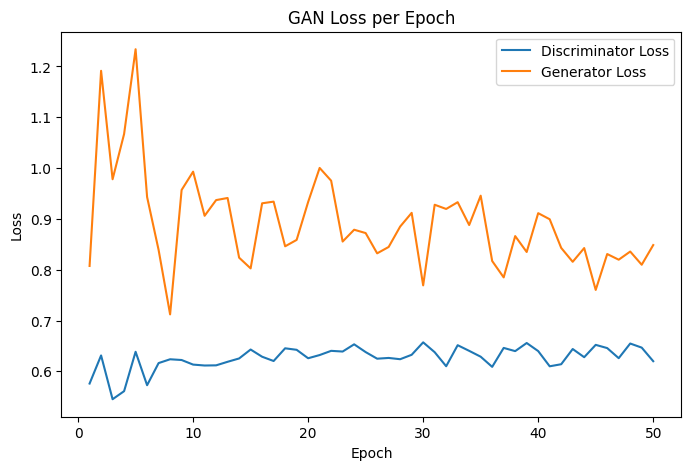

Training complete! Check the 'gan_samples' folder for generated images.
A plot of loss per epoch has been saved as 'loss_plot.png'.


In [9]:
if __name__ == "__main__":
    main()

In [10]:
# List files in the gan_samples folder
sample_files = os.listdir("gan_samples")
print("Generated images in gan_samples folder:")
print(sample_files)

Generated images in gan_samples folder:
['epoch_044.png', 'epoch_032.png', 'epoch_026.png', 'epoch_010.png', 'epoch_048.png', 'epoch_031.png', 'epoch_014.png', 'epoch_033.png', 'epoch_049.png', 'epoch_050.png', 'epoch_004.png', 'epoch_008.png', 'epoch_017.png', 'epoch_013.png', 'epoch_009.png', 'epoch_016.png', 'epoch_029.png', 'epoch_020.png', 'epoch_019.png', 'epoch_022.png', 'epoch_038.png', 'epoch_007.png', 'epoch_002.png', 'epoch_034.png', 'epoch_025.png', 'epoch_047.png', 'epoch_035.png', 'epoch_006.png', 'epoch_024.png', 'epoch_028.png', 'epoch_030.png', 'epoch_015.png', 'epoch_012.png', 'epoch_041.png', 'epoch_005.png', 'epoch_001.png', 'epoch_027.png', 'epoch_039.png', 'epoch_042.png', 'epoch_046.png', 'epoch_043.png', 'epoch_018.png', 'epoch_040.png', 'epoch_045.png', 'epoch_021.png', 'epoch_003.png', 'epoch_023.png', 'epoch_037.png', 'epoch_011.png', 'epoch_036.png']


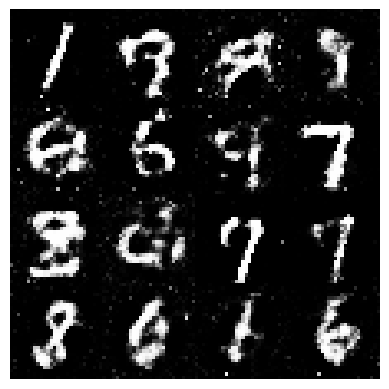

In [11]:
from PIL import Image

# Path to the image
image_path = os.path.join("gan_samples", "epoch_010.png")

# Open and display the image
image = Image.open(image_path)
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

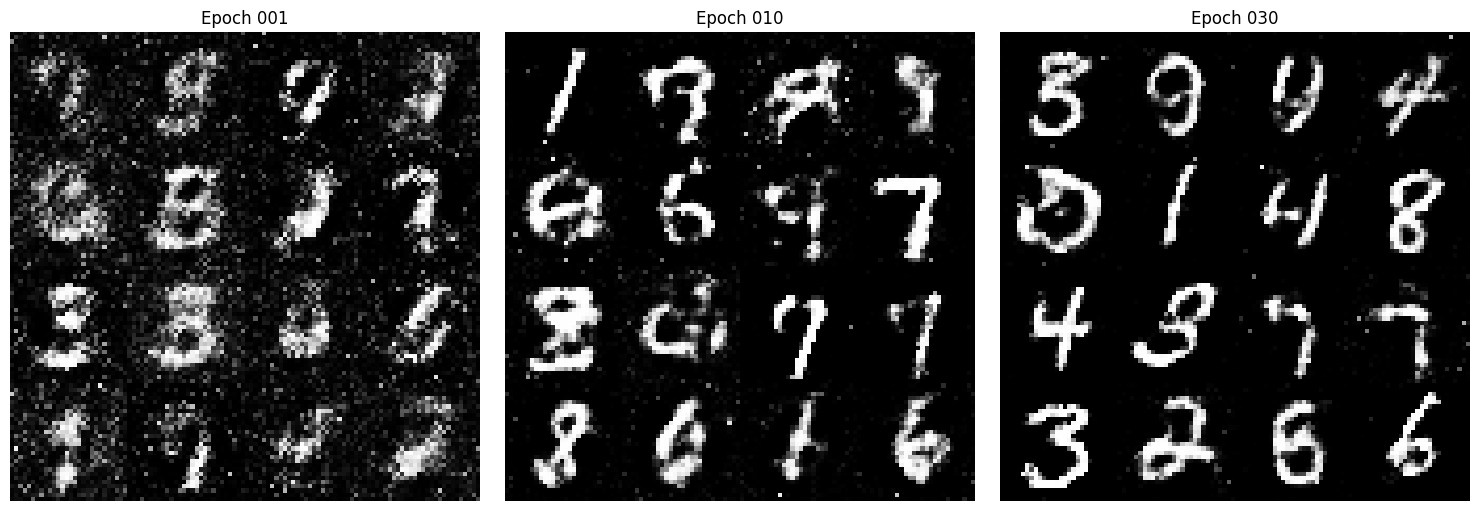

In [12]:
# List of image filenames to display
image_files = ["epoch_001.png", "epoch_010.png", "epoch_030.png"]

# Create a subplot grid
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))

# Display each image
for i, filename in enumerate(image_files):
    image_path = os.path.join("gan_samples", filename)
    image = Image.open(image_path)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Epoch {filename.split('_')[1].split('.')[0]}")

plt.tight_layout()
plt.show()

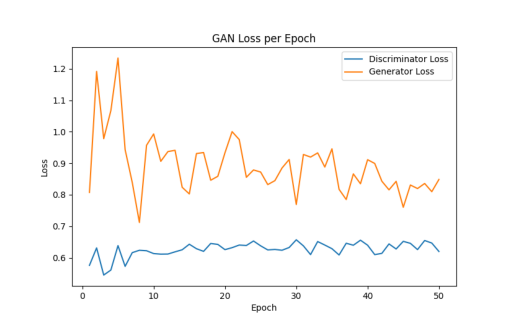

In [13]:
# Path to the loss plot
loss_plot_path = "loss_plot.png"

# Open and display the loss plot
loss_plot = Image.open(loss_plot_path)
plt.imshow(loss_plot)
plt.axis('off')  # Hide axes
plt.show()

In [14]:
from google.colab import files
import shutil

# Compress the gan_samples folder into a zip file
shutil.make_archive("gan_samples", 'zip', "gan_samples")

# Download the zip file
files.download("gan_samples.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>